In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import functools
import requests

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.feature_column as fc 

In [2]:
%matplotlib inline

In [3]:
tf.__version__

'2.0.0-alpha0'

#### Download data from Kaggle

In [4]:
!mkdir -p data
!kaggle competitions download -c titanic -p data

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# Path of data and exported models
TRAIN_PATH = os.path.join('data', 'train.csv')
TEST_PATH = os.path.join('data', 'test.csv')
MODEL_DIR = os.path.join('model')
EXPORT_DIR = os.path.join('savedmodel')

In [6]:
# Feature selection
BUCKET_QUANTILES = [0.2, 0.4, 0.6, 0.8]

CATEGORICAL_COLUMNS = ['Sex']
NUMERIC_COLUMNS = ['Pclass', 'Fare']
BUCKETIZED_COLUMNS = ['Age']
FEATURES_COLUMNS = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS + BUCKETIZED_COLUMNS

TARGETS = 'Survived'

In [7]:
# Feature engineering columns
FEATURE_CLIP_TRANS = ['Fare']
FEATURE_LOG1P_TRANS = ['Fare']
FEATURE_MIN_MAX_NORM = NUMERIC_COLUMNS

In [8]:
df = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

In [9]:
# Split the training data into training and validation sets 
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=42, shuffle=True, stratify=df[TARGETS])
df_train.shape, df_valid.shape, df_test.shape

((712, 12), (179, 12), (418, 11))

In [10]:
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


#### Define data importing functions

In [12]:
def input_fn(df, batch_size=10, num_epochs=None, shuffle=False, is_inference=False):
    
    features = df[FEATURES_COLUMNS]
    features = {key: np.array(value) for key, value in dict(features).items()}

    if not is_inference:
        targets = df[TARGETS]
        pairs = (features, targets)
    else:
        pairs = features

    ds = tf.data.Dataset.from_tensor_slices(pairs) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    
    return ds

In [13]:
# TensorFlow Dataset
ds = input_fn(df_train)
ds

<RepeatDataset shapes: ({Sex: (None,), Pclass: (None,), Fare: (None,), Age: (None,)}, (None,)), types: ({Sex: tf.string, Pclass: tf.int64, Fare: tf.float64, Age: tf.float64}, tf.int32)>

In [14]:
# Check if we get desired input batches
for i, sample in enumerate(ds.take(2)):
    print('-- batch index: {}'.format(i))
    for f in FEATURES_COLUMNS:
        print('---- feature {}: {}'.format(f, sample[0][f]))
    
    print('---- targets: {}'.format(sample[1]))
    print()

-- batch index: 0
---- feature Sex: [b'male' b'male' b'male' b'female' b'female' b'male' b'male' b'male'
 b'male' b'female']
---- feature Pclass: [3 2 1 3 2 3 3 1 3 3]
---- feature Fare: [ 56.4958   0.     221.7792   9.35    26.25     8.4333  56.4958 227.525
   7.75    18.    ]
---- feature Age: [nan nan nan 18. 31. 21. 26. nan nan 31.]
---- targets: [1 0 0 1 1 0 1 0 1 0]

-- batch index: 1
---- feature Sex: [b'male' b'female' b'male' b'male' b'male' b'female' b'male' b'male'
 b'male' b'female']
---- feature Pclass: [1 3 3 1 3 1 3 3 3 3]
---- feature Fare: [35.5     9.825  69.55   26.55    7.8    90.      7.7333  7.25    6.45
 25.4667]
---- feature Age: [56. 21. nan 56. 21. 33. 21. nan 43. nan]
---- targets: [1 0 0 0 0 1 0 0 0 0]



In [15]:
# Create data importing functions for our model at training, evaluation and predicting stage respectively.
train_input_fn = functools.partial(input_fn, df_train, batch_size=64, num_epochs=100, shuffle=True)
eval_input_fn = functools.partial(input_fn, df_valid, batch_size=64, num_epochs=1, shuffle=False)
predict_input_fn = functools.partial(input_fn, df_test, batch_size=64, num_epochs=1, shuffle=False, is_inference=True)

#### Feature engineering

Note that we encapsulate all preprocessing and transformation pipeline inside a `norm` func, which is gonna be passed to `tf.feature_columns` as an arg

In [16]:
def norm(tensor, feature_name, df, 
         clip_list=FEATURE_CLIP_TRANS, 
         log1p_list=FEATURE_LOG1P_TRANS, 
         minmax_list=FEATURE_MIN_MAX_NORM):
    
    df = df.copy(deep=True)
    
    if feature_name in clip_list:
        lower, upper = df[feature_name].quantile([0.05, 0.95])
        df[feature_name] = df[feature_name].clip(lower=lower, upper=upper)
        lower_b = tf.broadcast_to(tf.cast(lower, tensor.dtype), tf.shape(tensor))
        upper_b = tf.broadcast_to(tf.cast(upper, tensor.dtype), tf.shape(tensor))
        tensor = tf.where(tf.greater_equal(tensor, lower_b), tensor, lower_b)
        tensor = tf.where(tf.less_equal(tensor, upper_b), tensor, upper_b)

    if feature_name in log1p_list:
        df[feature_name] = np.log1p(df[feature_name])
        tensor = tf.math.log1p(tf.cast(tensor, tf.float32))
        
    if feature_name in minmax_list:
        min_val, max_val = df[feature_name].min(), df[feature_name].max()
        range_val = max_val - min_val
        tensor = tf.truediv(
            tf.subtract(tensor, tf.cast(min_val, tensor.dtype)), 
            tf.cast(range_val, tensor.dtype))
    
    return tensor

In [17]:
def get_feature_columns(df, categorical_columns=None, numeric_columns=None, bucketized_columns=None, bucket_quantiles=None):

    feature_columns = []
    
    # Categorical features
    if categorical_columns is not None:
        for feature_name in categorical_columns:
            vocab = df[feature_name].unique()
            feature_columns.append(
                fc.indicator_column(
                    fc.categorical_column_with_vocabulary_list(feature_name, vocab, num_oov_buckets=1)
                )
            )

    # Numeric features
    if numeric_columns is not None:
        for feature_name in numeric_columns:
            feature_columns.append(
                fc.numeric_column(
                    feature_name, 
                    default_value=0.0, 
                    dtype=tf.float32, 
                    normalizer_fn=lambda x, feature_name=feature_name, df=df: norm(x, feature_name, df)
                )
            )

    # Bucketized features
    if bucketized_columns is not None and bucket_quantiles is not None:
        for feature_name in bucketized_columns:
            fc_num_to_bucket = fc.numeric_column(feature_name, default_value=0.0, dtype=tf.float32)
            feature_columns.append(
                fc.bucketized_column(
                    fc_num_to_bucket,
                    boundaries=df[feature_name].quantile(bucket_quantiles).values.tolist()
                )
            )
            
    return feature_columns

In [18]:
feature_columns = get_feature_columns(df_train, CATEGORICAL_COLUMNS, NUMERIC_COLUMNS, BUCKETIZED_COLUMNS, BUCKET_QUANTILES)

In [19]:
feature_columns

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=1)),
 NumericColumn(key='Pclass', shape=(1,), default_value=(0.0,), dtype=tf.float32, normalizer_fn=<function get_feature_columns.<locals>.<lambda> at 0x1128cfa60>),
 NumericColumn(key='Fare', shape=(1,), default_value=(0.0,), dtype=tf.float32, normalizer_fn=<function get_feature_columns.<locals>.<lambda> at 0x1128cfae8>),
 BucketizedColumn(source_column=NumericColumn(key='Age', shape=(1,), default_value=(0.0,), dtype=tf.float32, normalizer_fn=None), boundaries=(19.0, 25.0, 32.0, 41.200000000000045))]

In [20]:
def demo(feature_columns, take=1):
    input_layer = tf.keras.layers.DenseFeatures(feature_columns)
    for feature_batch, label_batch in ds.take(take):
        batch = input_layer(feature_batch).numpy()
        print('Batch shape: ', batch.shape)
        print(batch)
        

# The column of transformed output maxtrix is sorted alphabetically by feature keys, 
# that is `Age` (None, 5) followed by `Fare` (None, 1), `Pclass` (None, 1) and lastly `Sex` (None, 2+1), total of 10, 
# not necessarily the same as the order columns we appended in `feature_columns` list
demo(feature_columns)  

W0312 21:42:35.262887 4602074560 deprecation.py:323] From /Users/jameswong/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:2758: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0312 21:42:35.264359 4602074560 deprecation.py:323] From /Users/jameswong/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:2902: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0312 21:42:35.280864 4602074560 deprecation.py:323] From /Users/jameswong/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:4307: IndicatorColumn._variable_shape (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instruct

Batch shape:  (10, 10)
[[0.         0.         0.         0.         1.         0.7434285
  1.         1.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.5        1.         0.         0.        ]
 [0.         0.         0.         0.         1.         1.
  0.         1.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.09195788
  1.         0.         1.         0.        ]
 [0.         0.         1.         0.         0.         0.4597527
  0.5        0.         1.         0.        ]
 [0.         1.         0.         0.         0.         0.05672324
  1.         1.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.7434285
  1.         1.         0.         0.        ]
 [0.         0.         0.         0.         1.         1.
  0.         1.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.02815568
  1.         1. 

In [21]:
linear_estimator = tf.estimator.LinearClassifier(
    feature_columns=feature_columns,
    model_dir=MODEL_DIR
)

In [22]:
linear_estimator.train(train_input_fn)

W0312 21:42:35.301193 4602074560 deprecation.py:323] From /Users/jameswong/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/training/training_util.py:238: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W0312 21:42:35.726919 4602074560 deprecation.py:506] From /Users/jameswong/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py:187: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0312 21:42:35.958639 4602074560 deprecation.py:323] From /Users/jameswong/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/train

In [23]:
linear_estimator.get_variable_names()

['global_step',
 'linear/linear_model/Age_bucketized/weights',
 'linear/linear_model/Age_bucketized/weights/part_0/Ftrl',
 'linear/linear_model/Age_bucketized/weights/part_0/Ftrl_1',
 'linear/linear_model/Fare/weights',
 'linear/linear_model/Fare/weights/part_0/Ftrl',
 'linear/linear_model/Fare/weights/part_0/Ftrl_1',
 'linear/linear_model/Pclass/weights',
 'linear/linear_model/Pclass/weights/part_0/Ftrl',
 'linear/linear_model/Pclass/weights/part_0/Ftrl_1',
 'linear/linear_model/Sex_indicator/weights',
 'linear/linear_model/Sex_indicator/weights/part_0/Ftrl',
 'linear/linear_model/Sex_indicator/weights/part_0/Ftrl_1',
 'linear/linear_model/bias_weights',
 'linear/linear_model/bias_weights/part_0/Ftrl',
 'linear/linear_model/bias_weights/part_0/Ftrl_1']

In [24]:
linear_estimator.get_variable_value('linear/linear_model/Fare/weights')

array([[-0.25761795]], dtype=float32)

In [25]:
linear_estimator.get_variable_value('linear/linear_model/Age_bucketized/weights')

array([[ 0.87398267],
       [ 0.16752891],
       [ 0.14393766],
       [ 0.22214134],
       [-0.19652022]], dtype=float32)

In [26]:
linear_estimator.get_variable_value('linear/linear_model/bias_weights')

array([0.6896507], dtype=float32)

In [27]:
# Evaluation results
result = linear_estimator.evaluate(eval_input_fn)
result

{'accuracy': 0.7821229,
 'accuracy_baseline': 0.61452514,
 'auc': 0.83695656,
 'auc_precision_recall': 0.78446585,
 'average_loss': 0.47682607,
 'label/mean': 0.38547486,
 'loss': 0.47396708,
 'precision': 0.8,
 'prediction/mean': 0.3775963,
 'recall': 0.5797101,
 'global_step': 2400}

#### Predictions

In [28]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [29]:
pred_dicts = list(linear_estimator.predict(predict_input_fn))
pred_dicts[:2]

[{'logits': array([-2.2212594], dtype=float32),
  'logistic': array([0.09785759], dtype=float32),
  'probabilities': array([0.9021424 , 0.09785757], dtype=float32),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object)},
 {'logits': array([-0.00565559], dtype=float32),
  'logistic': array([0.49858612], dtype=float32),
  'probabilities': array([0.5014139, 0.4985861], dtype=float32),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object)}]

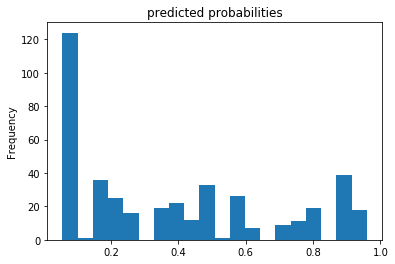

In [30]:
# The distribution of predicted survival likelihood in test dataset
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
classes = pd.Series([pred['class_ids'][0] for pred in pred_dicts])
probs.plot(kind='hist', bins=20, title='predicted probabilities')

#### Export `Estimator` to `SavedModel`  

In [31]:
# Set serving input function before exporting our model and serving it
features_raw_placeholder = {
    'Sex': tf.keras.backend.placeholder(shape=(None, ), dtype=tf.string, name='input_sex'),
    'Pclass': tf.keras.backend.placeholder(shape=(None, ), dtype=tf.float32, name='input_pclass'),
    'Fare': tf.keras.backend.placeholder(shape=(None, ), dtype=tf.float32, name='input_fare'),
    'Age': tf.keras.backend.placeholder(shape=(None, ), dtype=tf.float32, name='input_age')
}

serving_raw_input_fn = tf.estimator.export.build_raw_serving_input_receiver_fn(
    features=features_raw_placeholder)

# Export the model
export_path = linear_estimator.export_saved_model(
    EXPORT_DIR, serving_raw_input_fn)

W0312 21:42:40.085338 4602074560 deprecation.py:323] From /Users/jameswong/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:201: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
W0312 21:42:40.086337 4602074560 tf_logging.py:161] Export includes no default signature!


In [32]:
# # If your input data at inference time is of serialized tf.Example format, then we can use a wrapper like below
# serving_input_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(
#     fc.make_parse_example_spec(feature_columns))
#
# export_path = linear_estimator.export_saved_model(
#     EXPORT_DIR, serving_input_fn)

In [33]:
# Load the SavedModel back and find out what the default graph signature is, which will be used when inferencing
loaded = tf.saved_model.load(export_path)
print(list(loaded.signatures.keys())) 

['predict']


In [34]:

infer = loaded.signatures["predict"]
print(infer.structured_outputs)

{'logistic': <tf.Tensor 'IdentityN:2' shape=(None, 1) dtype=float32>, 'probabilities': <tf.Tensor 'IdentityN:4' shape=(None, 2) dtype=float32>, 'class_ids': <tf.Tensor 'IdentityN:0' shape=(None, 1) dtype=int64>, 'logits': <tf.Tensor 'IdentityN:3' shape=(None, 1) dtype=float32>, 'classes': <tf.Tensor 'IdentityN:1' shape=(None, 1) dtype=string>}


In [35]:
# This is what our directory looks like now
!tree .

.
├── data
│   ├── gender_submission.csv
│   ├── test.csv
│   └── train.csv
├── model
│   ├── checkpoint
│   ├── eval
│   │   ├── events.out.tfevents.1552395498.jameswj.local
│   │   └── events.out.tfevents.1552398159.jameswj.local
│   ├── events.out.tfevents.1552395495.jameswj.local
│   ├── events.out.tfevents.1552398155.jameswj.local
│   ├── graph.pbtxt
│   ├── model.ckpt-0.data-00000-of-00002
│   ├── model.ckpt-0.data-00001-of-00002
│   ├── model.ckpt-0.index
│   ├── model.ckpt-0.meta
│   ├── model.ckpt-1200.data-00000-of-00002
│   ├── model.ckpt-1200.data-00001-of-00002
│   ├── model.ckpt-1200.index
│   ├── model.ckpt-1200.meta
│   ├── model.ckpt-2400.data-00000-of-00002
│   ├── model.ckpt-2400.data-00001-of-00002
│   ├── model.ckpt-2400.index
│   └── model.ckpt-2400.meta
├── savedmodel
│   ├── 1552395499
│   │   ├── saved_model.pb
│   │   └── variables
│   │       ├── variables.data-00000-of-00002
│   │       ├── variables.data-00001-of-00002
│   │       └── variables.index
│   └─

#### Serve the trained model with Docker

```bash
$ # Spin up a Docker container (container env defaults: model_dir => /models, default model_name => model)
$ EXPORT_BASE_DIR=/Users/jameswong/WorkingDirectory/Python/labs/tf2/savedmodel/
$ docker run -t --rm --name tf -p 8501:8501 -v "$EXPORT_BASE_DIR:/models/model" tensorflow/serving 
```

In [36]:
# Upon being requested for inferencs, it throws back results the same as before
!curl -d '{"signature_name":"predict","inputs":{"Sex": ["male", "female"], "Pclass": [3, 3], "Fare": [7.8292,7.0000], "Age": [34.5, 47]}}' \
  -X POST http://localhost:8501/v1/models/model:predict             

{
    "outputs": {
        "logistic": [
            [
                0.0978576
            ],
            [
                0.498586
            ]
        ],
        "class_ids": [
            [
                0
            ],
            [
                0
            ]
        ],
        "probabilities": [
            [
                0.902142,
                0.0978576
            ],
            [
                0.501414,
                0.498586
            ]
        ],
        "classes": [
            [
                "0"
            ],
            [
                "0"
            ]
        ],
        "logits": [
            [
                -2.22126
            ],
            [
                -0.00565559
            ]
        ]
    }
}

In [38]:
# An alternative approach is to make predictions directly in Python
data = '{"signature_name": "predict", "inputs": {"Sex": ["male", "female"], "Pclass": [3, 3], "Fare": [7.8292,7.0000], "Age": [34.5, 47]}}'
url = 'http://localhost:8501/v1/models/model/versions/1552398159:predict'
response = requests.post(url, data=data)

if response.ok:
    print(response.json())
    

{'outputs': {'class_ids': [[0], [0]], 'probabilities': [[0.902142, 0.0978576], [0.501414, 0.498586]], 'classes': [['0'], ['0']], 'logits': [[-2.22126], [-0.00565559]], 'logistic': [[0.0978576], [0.498586]]}}
